In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data
from combinators.model import foldable
from combinators.inference import importance, mcmc
from combinators import utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
T=100
dt=1
Boundary=6
signal_noise_ratio = 0.2

In [6]:
def generate_trajectory():
    x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, 1, Boundary)
    STATEs = np.zeros((T+1, 4))
    Disps = np.zeros((T, 2))
    init_state = np.array([x0[0], y0[0], init_v_rand_dir[0, 0], init_v_rand_dir[0, 1]])

    STATEs, Disps, _ = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)
    return STATEs, Disps

In [7]:
import os.path

if os.path.isfile('examples/dynamical_ball/trajectory.data'):
    trajectory_dict = torch.load('examples/dynamical_ball/trajectory.data')
    STATEs = trajectory_dict['STATEs']
    Disps = trajectory_dict['Disps']
else:
    STATEs, Disps = generate_trajectory()
    STATEs = torch.tensor(STATEs, dtype=torch.float32)
    Disps = torch.tensor(Disps, dtype=torch.float32)
    trajectory_dict = {
        'STATEs': STATEs,
        'Disps': Disps,
    }
    torch.save(trajectory_dict, 'examples/dynamical_ball/trajectory.data')

In [8]:
num_particles = (100,)

In [9]:
init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)

In [10]:
bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)

In [11]:
def generate_trajectory_trace():
    trajectory = STATEs
    displacements = Disps

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = point[:2]
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [12]:
def accumulate_trajectory(inference):
    initial_position = inference['Reduce/Step(0)/InitBallDynamics']['position_0'].value
    initial_velocity = inference['Reduce/Step(0)/InitBallDynamics']['velocity_0'].value
    velocities = torch.zeros(initial_velocity.shape[0], T + 1, 2)
    velocities[:, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, t] = inference['Reduce/Step(%d)/StepBallDynamics' % (t-1)]['velocity_%d' % t].value
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, 0, :]

In [13]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [14]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [15]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [16]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [17]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [18]:
def proposal_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Step(step_proposal, initializer=init_proposal),
                           lambda: range(T))

In [19]:
def training_initializer():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    return importance.Propose(init_bouncing_ball, init_proposal)

In [20]:
def training_step():
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return importance.Propose(bouncing_ball_step, step_proposal)

In [21]:
def training_model():
    return foldable.Reduce(foldable.Step(training_step(), initializer=training_initializer()), lambda: range(T))

03/01/2019 10:55:26 ELBO=-4.33645508e+02 at epoch 1
03/01/2019 10:55:26 ELBO=-4.50500824e+02 at epoch 2
03/01/2019 10:55:26 ELBO=-4.50823486e+02 at epoch 3
03/01/2019 10:55:26 ELBO=-4.35952423e+02 at epoch 4
03/01/2019 10:55:27 ELBO=-4.46238312e+02 at epoch 5
03/01/2019 10:55:27 ELBO=-4.51122375e+02 at epoch 6
03/01/2019 10:55:27 ELBO=-4.19477142e+02 at epoch 7
03/01/2019 10:55:27 ELBO=-4.38852661e+02 at epoch 8
03/01/2019 10:55:27 ELBO=-4.38495361e+02 at epoch 9
03/01/2019 10:55:28 ELBO=-4.34250000e+02 at epoch 10
03/01/2019 10:55:28 ELBO=-4.34597198e+02 at epoch 11
03/01/2019 10:55:28 ELBO=-4.18243866e+02 at epoch 12
03/01/2019 10:55:28 ELBO=-4.18766296e+02 at epoch 13
03/01/2019 10:55:28 ELBO=-4.17385498e+02 at epoch 14
03/01/2019 10:55:29 ELBO=-4.13828278e+02 at epoch 15
03/01/2019 10:55:29 ELBO=-4.09021667e+02 at epoch 16
03/01/2019 10:55:29 ELBO=-4.04163788e+02 at epoch 17
03/01/2019 10:55:29 ELBO=-4.01476593e+02 at epoch 18
03/01/2019 10:55:29 ELBO=-3.97217010e+02 at epoch 19
03

Epoch   392: reducing learning rate of group 0 to 5.0000e-02.


03/01/2019 10:56:46 ELBO=-1.34406418e+02 at epoch 395
03/01/2019 10:56:46 ELBO=-1.42300247e+02 at epoch 396
03/01/2019 10:56:47 ELBO=-1.30917648e+02 at epoch 397
03/01/2019 10:56:47 ELBO=-1.26524925e+02 at epoch 398
03/01/2019 10:56:47 ELBO=-1.28370087e+02 at epoch 399
03/01/2019 10:56:47 ELBO=-1.27245262e+02 at epoch 400
03/01/2019 10:56:47 ELBO=-1.28581665e+02 at epoch 401
03/01/2019 10:56:47 ELBO=-1.19018356e+02 at epoch 402
03/01/2019 10:56:48 ELBO=-1.21929543e+02 at epoch 403
03/01/2019 10:56:48 ELBO=-1.27250969e+02 at epoch 404
03/01/2019 10:56:48 ELBO=-1.13085983e+02 at epoch 405
03/01/2019 10:56:48 ELBO=-1.17428719e+02 at epoch 406
03/01/2019 10:56:48 ELBO=-1.07387749e+02 at epoch 407
03/01/2019 10:56:49 ELBO=-1.39816528e+02 at epoch 408
03/01/2019 10:56:49 ELBO=-1.22988518e+02 at epoch 409
03/01/2019 10:56:49 ELBO=-1.22050613e+02 at epoch 410
03/01/2019 10:56:49 ELBO=-1.34277939e+02 at epoch 411
03/01/2019 10:56:49 ELBO=-1.17659836e+02 at epoch 412
03/01/2019 10:56:50 ELBO=-1.

Epoch   628: reducing learning rate of group 0 to 2.5000e-02.


03/01/2019 10:57:36 ELBO=-1.14886879e+02 at epoch 631
03/01/2019 10:57:36 ELBO=-1.05995171e+02 at epoch 632
03/01/2019 10:57:36 ELBO=-1.10094711e+02 at epoch 633
03/01/2019 10:57:37 ELBO=-1.19800209e+02 at epoch 634
03/01/2019 10:57:37 ELBO=-1.18583282e+02 at epoch 635
03/01/2019 10:57:37 ELBO=-1.12260941e+02 at epoch 636
03/01/2019 10:57:37 ELBO=-1.09461479e+02 at epoch 637
03/01/2019 10:57:38 ELBO=-1.04068962e+02 at epoch 638
03/01/2019 10:57:38 ELBO=-9.58692474e+01 at epoch 639
03/01/2019 10:57:38 ELBO=-9.65146637e+01 at epoch 640
03/01/2019 10:57:38 ELBO=-1.02425873e+02 at epoch 641
03/01/2019 10:57:38 ELBO=-8.59044647e+01 at epoch 642
03/01/2019 10:57:39 ELBO=-1.01137459e+02 at epoch 643
03/01/2019 10:57:39 ELBO=-9.99059219e+01 at epoch 644
03/01/2019 10:57:39 ELBO=-1.00446358e+02 at epoch 645
03/01/2019 10:57:40 ELBO=-1.13291969e+02 at epoch 646
03/01/2019 10:57:40 ELBO=-9.50037689e+01 at epoch 647
03/01/2019 10:57:40 ELBO=-9.53265076e+01 at epoch 648
03/01/2019 10:57:40 ELBO=-1.

Epoch   903: reducing learning rate of group 0 to 1.2500e-02.


03/01/2019 10:58:31 ELBO=-8.38112869e+01 at epoch 906
03/01/2019 10:58:31 ELBO=-8.34593658e+01 at epoch 907
03/01/2019 10:58:31 ELBO=-9.23956451e+01 at epoch 908
03/01/2019 10:58:31 ELBO=-8.26316528e+01 at epoch 909
03/01/2019 10:58:31 ELBO=-9.72732391e+01 at epoch 910
03/01/2019 10:58:32 ELBO=-9.36605148e+01 at epoch 911
03/01/2019 10:58:32 ELBO=-9.31591034e+01 at epoch 912
03/01/2019 10:58:32 ELBO=-8.14725876e+01 at epoch 913
03/01/2019 10:58:32 ELBO=-9.46495972e+01 at epoch 914
03/01/2019 10:58:32 ELBO=-9.05686798e+01 at epoch 915
03/01/2019 10:58:33 ELBO=-7.87316437e+01 at epoch 916
03/01/2019 10:58:33 ELBO=-7.87396851e+01 at epoch 917
03/01/2019 10:58:33 ELBO=-9.19033356e+01 at epoch 918
03/01/2019 10:58:33 ELBO=-7.77864227e+01 at epoch 919
03/01/2019 10:58:33 ELBO=-9.05941086e+01 at epoch 920
03/01/2019 10:58:34 ELBO=-8.75558090e+01 at epoch 921
03/01/2019 10:58:34 ELBO=-8.87013245e+01 at epoch 922
03/01/2019 10:58:34 ELBO=-7.89907761e+01 at epoch 923
03/01/2019 10:58:34 ELBO=-1.

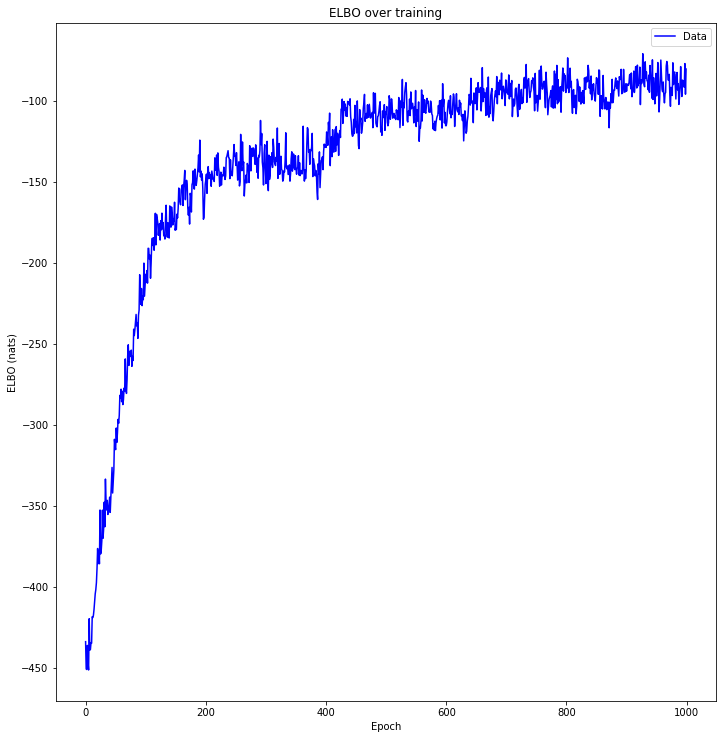

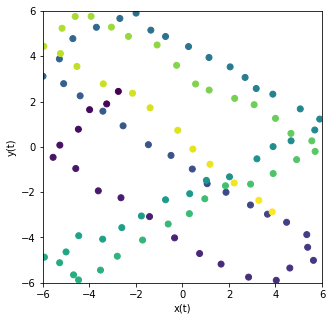

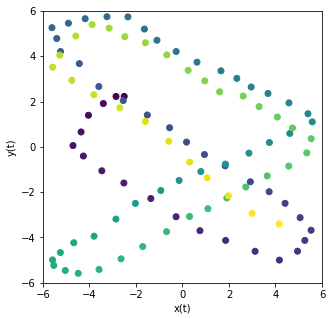

In [22]:
modal_directions = torch.zeros(1, 4, 2)

trajectory, displacements, data = generate_trajectory_trace()

importance_sampler = training_model()

inference, trained_params, elbos = importance.variational_importance(
    importance_sampler, 1000, data,
    use_cuda=False, lr=1e-1, inclusive_kl=False,
    patience=100,
)
utils.plot_evidence_bounds(elbos, True)

bouncing_ball_posterior = mcmc.resample_move_smc(importance_sampler, moves=5)
(direction, position, uncertainty, noise), inference, _ = bouncing_ball_posterior(data=data)
inferred_trajectory = accumulate_trajectory(inference)

positions = inferred_trajectory.mean(dim=0).cpu().detach()
displacements = torch.stack([inference['Reduce/Step(%d)/StepBallDynamics' % t]['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)

graph_original_trajectory(trajectory, T, 0)
graph_inferred_trajectory(positions, T, 0)
graph_displacement_trajectories(velocity_steps, displacements, T, 0)

plt.close('all')

In [23]:
trained_params

"{'noise__loc': 'tensor([-1.7535, -1.7452], grad_fn=<CloneBackward>)', 'noise__scale': 'tensor([-2.4664, -2.4145], grad_fn=<CloneBackward>)', 'position_0__covariance_matrix': 'tensor([[-1.7972,  0.0000],\n        [ 0.0294, -1.8026]], grad_fn=<CloneBackward>)', 'position_0__loc': 'tensor([-2.3117,  2.2313], grad_fn=<CloneBackward>)', 'uncertainty__loc': 'tensor([-1.0695, -1.3050], grad_fn=<CloneBackward>)', 'uncertainty__scale': 'tensor([-2.3234, -2.4254], grad_fn=<CloneBackward>)', 'velocities__loc': 'tensor([[-0.7703, -0.3626],\n        [-0.6019, -0.6880],\n        [-0.5997, -0.7163],\n        [-0.1601, -0.5461],\n        [ 0.6979, -0.5667],\n        [ 0.9240, -0.7315],\n        [ 1.0126, -0.5710],\n        [ 1.1699, -0.7472],\n        [ 1.0288, -0.8651],\n        [ 1.0514, -0.7112],\n        [ 1.0197, -0.4699],\n        [ 1.1050, -0.5173],\n        [ 1.1415, -0.2377],\n        [ 0.8042,  0.4097],\n        [ 0.8840,  0.3809],\n        [ 0.8388,  0.4879],\n        [-0.3285,  0.5820],\n

In [24]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])
    print('Inferred position at time %d' % t, positions[t])
    print('MSE at time %d' % t, ((data['position_%d' % t] - positions[t])**2).sum())

Position at time 0 tensor([-2.7566,  2.4511])
Inferred position at time 0 tensor([-2.5055,  2.2292])
MSE at time 0 tensor(0.1123)
Position at time 1 tensor([-3.2588,  1.8982])
Inferred position at time 1 tensor([-2.8568,  2.2265])
MSE at time 1 tensor(0.2694)
Position at time 2 tensor([-3.9935,  1.6434])
Inferred position at time 2 tensor([-3.4034,  1.9142])
MSE at time 2 tensor(0.4216)
Position at time 3 tensor([-4.4764,  0.7806])
Inferred position at time 3 tensor([-4.0444,  1.3971])
MSE at time 3 tensor(0.5668)
Position at time 4 tensor([-5.2735,  0.0781])
Inferred position at time 4 tensor([-4.3604,  0.6599])
MSE at time 4 tensor(1.1722)
Position at time 5 tensor([-5.5633, -0.4598])
Inferred position at time 5 tensor([-4.7079,  0.0595])
MSE at time 5 tensor(1.0014)
Position at time 6 tensor([-4.5883, -0.9539])
Inferred position at time 6 tensor([-4.2612, -0.4033])
MSE at time 6 tensor(0.4102)
Position at time 7 tensor([-3.6189, -1.9389])
Inferred position at time 7 tensor([-3.4662,

In [25]:
bouncing_ball_smc = importance.smc(importance_sampler)
(direction, position, uncertainty, noise), inference, _ = bouncing_ball_smc(data=data)
inferred_trajectory = accumulate_trajectory(inference)
positions = inferred_trajectory.mean(dim=0).cpu().detach()

In [26]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])
    print('MSE at time %d' % t, ((data['position_%d' % t] - positions[t])**2).sum())

Inferred position at time 0 tensor([-2.4819,  2.1704])
MSE at time 0 tensor(0.1542)
Inferred position at time 1 tensor([-3.3289,  1.7995])
MSE at time 1 tensor(0.0146)
Inferred position at time 2 tensor([-4.0012,  1.3422])
MSE at time 2 tensor(0.0908)
Inferred position at time 3 tensor([-4.6516,  0.8644])
MSE at time 3 tensor(0.0377)
Inferred position at time 4 tensor([-5.1032,  0.0783])
MSE at time 4 tensor(0.0290)
Inferred position at time 5 tensor([-5.2163, -0.3953])
MSE at time 5 tensor(0.1246)
Inferred position at time 6 tensor([-4.7725, -0.9185])
MSE at time 6 tensor(0.0352)
Inferred position at time 7 tensor([-3.8661, -1.5126])
MSE at time 7 tensor(0.2427)
Inferred position at time 8 tensor([-2.9283, -2.1092])
MSE at time 8 tensor(0.0989)
Inferred position at time 9 tensor([-1.8280, -2.6762])
MSE at time 9 tensor(0.3306)
Inferred position at time 10 tensor([-0.6714, -3.5814])
MSE at time 10 tensor(0.2998)
Inferred position at time 11 tensor([ 0.4621, -4.3122])
MSE at time 11 ten

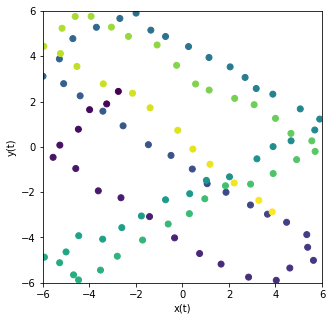

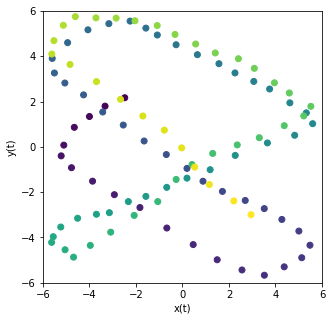

In [27]:
graph_original_trajectory(trajectory, T, 0)
graph_inferred_trajectory(positions, T, 0)